# Обучаем линейную регрессию

Помимо pandas нам сегодня понадобится библиотека [scikit-learn](https://scikit-learn.org/stable/index.html):
+ реализации большинства алгоритмов машинного обучения
+ модули для предобработки данных, оценки качетва модели и много чего другого
+ очень хорошая документация 


## Загружаем датасет

In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/arunk13/MSDA-Assignments/master/IS607Fall2015/Assignment3/student-mat.csv', delimiter=';')

In [27]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


Отделяем целевую переменную, удаляем ненужные столбцы (G1 и G2). 

In [0]:
target = data['G3']

In [0]:
data = data.drop(columns=['G1', 'G2', 'G3'])

In [30]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences'],
      dtype='object')

## Предобработка данных

Комепьютер  понимает только чиселки, поэтому все признаки со строковыми значениями нужно превратить в чиселки.

### Бинарные признаки 

Достаточно просто заменить одно из возможных значений на 1, а другое на 0. 

Можно написать руками, а можно воспользоваться классом [Label encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html): 
+ метод ***fit*** создает массив уникальных значений
+  метод ***transform*** заменяет значения на число - порядковый номер в массиве
+ ***fit_transform*** вызывает эти два метода по очереди (надо же)

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le = LabelEncoder()

In [33]:
for column in data.columns:
    if data[column].dtype == 'object' and len(data[column].unique()) == 2:
        print(column)
        data[column] = le.fit_transform(data[column])
        # # эквивалентно
        # le.fit(data[column])
        # data[column] = le.transform(data[column])
        


school
sex
address
famsize
Pstatus
schoolsup
famsup
paid
activities
nursery
higher
internet
romantic


In [34]:
# видим, что бинарные признаки (school, sex, address etc) превратились в чиловые (тип int64)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school        395 non-null int64
sex           395 non-null int64
age           395 non-null int64
address       395 non-null int64
famsize       395 non-null int64
Pstatus       395 non-null int64
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null int64
famsup        395 non-null int64
paid          395 non-null int64
activities    395 non-null int64
nursery       395 non-null int64
higher        395 non-null int64
internet      395 non-null int64
romantic      395 non-null int64
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 non-null int64


### Категориальные признаки 

Почему просто не заменить на числа с помощью Label Encoder?
+ В принципе так можно делать.
+ Но это не очень правильно, т.к. весь смысл категориальности теряется и появляются ложные интерпретации.
+ Ведь значения категориальных признаков нельзя сравнить между собой или расположить по порядку,в отличие от чисел.  

На примере признака Mjob, если заменить на значения числа (health -> 0, teacher -> 1, at_home -> 2, services -> 3, other -> 4), то получается что 
+ health < teacher < at_home < services < other 
+ teacher + at_home = services 
+ и т.д.
+ и все это не свойство данных, а свойство выбранной нами кодировки!

С категориальными признаками правильнее использовать One-hot encoding - создать N новых бинарных признаков (N - количество уникальных значений), 1 - в том столбце, где значение признака равно названию столбца, в остальных - 0. 
![](https://i.imgur.com/mtimFxh.png)


In [0]:
# drop_first - удаляем одну из колонок, тк она восстанавливается по значениям других (то, что не Red и не Yellow - точно Green)
data = pd.get_dummies(data, drop_first=True)

In [36]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,15,1,1,1,1,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,0,0,0,0,0,1,0,0,0,1,0,1,0
3,0,0,15,1,0,1,4,2,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,1,0,0,0,0,0,1,0,1,0,0,1,0
4,0,0,16,1,0,1,3,3,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,0,1,0,0,0,1,0,0,1,0,0,0,0


## Обучающая и тестовая выборка 

+ Как проверить качество модели - сделать предсказания для объектов с известными ответами, сравнить предсказанные ответы с реальными. 
+ Если использовать для оценки качества ту же выборку, что и для обучения, скорее всего оценка выйдет оптимистически смещенной. 
+ Поэтому нужно отделить часть выборки, которая не будет использоваться при обучении, для того, чтобы потом на ней проверить качество. 
+ Размер тестовой выборки обычно -  20-30% от всех данных. 

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# фиксируем RANDOM_STATE для воспороизводимости результатов (при каждм перезапуске ячейки в тестовую выборку попадают одни и те же объекты,
# соотв-но значение метрики качества для одной и той же модели не будет меняться каждый раз)
RANDOM_STATE = 666
# train_test_split рандомно выбирает 25% объектов и соответсвующих им ответов
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=RANDOM_STATE)

In [39]:
# 39 признаков, 296 объектов в обучающй выборке
X_train.shape, y_train.shape

((296, 39), (296,))

In [40]:
# 39 признаков, 99 объектов в тестовой выборке
X_test.shape, y_test.shape

((99, 39), (99,))

## Создание и обучение модели 

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
 # создаем модель
lr = LinearRegression()

In [43]:
# обучаем модель
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Измерение качества

Посмотрим на среднюю абсолютную ошибку:   
\begin{equation*}
\text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|.
\end{equation*}    

Для каждого объекта посчитали модуль разницы  между предсказанным ответом и реальным и взяли среднее арифметическое:
MAE = sum(abs(y_true - y_pred))/len(y_true)


In [0]:
# предсказывем ответы для объектов тестовой выборки
y_pred = lr.predict(X_test)

In [0]:
from sklearn.metrics import mean_absolute_error

In [46]:
mean_absolute_error(y_test, y_pred)
# в среднем ошибается на 3 балла из 20 (помниим, что система 20-балльная)

3.024433147612863

In [47]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(25)

,Actual,Predicted
54,13,13.236107
299,16,10.908260
246,13,10.535321
17,10,8.664914
321,9,8.158382
165,12,10.425675
18,5,7.611132
56,15,13.737505
383,0,10.421948
48,14,10.038922


## Prediction error plot

+ На вертикальной оси - предсказанные значения, на горизонтальной - реальные. 
+ Чем ближе точки к диагонали, тем более точным является предсказание модели. 
+ Позволяет оценить на сколько и в какую сторону ошибается модель. 
+ В частности здесь мы видим, что она чаще занижает результаты (больше точек расположено ниже диагонали) и при этом совсем не может предсказывать 0 (и вообще не выдает оценку меньше, чем 2.5). 

In [0]:
import matplotlib.pyplot as plt
# нужно для того, чтобы графики отображались в аутпуте ячейки, а не в отдельном окне
%matplotlib inline 

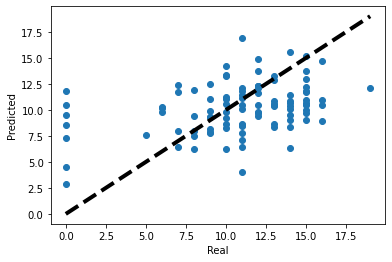

In [49]:
fig, ax = plt.subplots()
# рисуем синие точки, каждая точка - отдельный объект из тестовой выборки
ax.scatter(x=y_test, y=y_pred)
# рисуем диагональ 
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
# подписываем оси
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

## Веса признаков 

+ в атрибует модели ***coef_*** лежат веса признаков в модели (*w*)
+ чем больше абсолютное значение веса, тем важнее признак, тем больший вклад он вносит в итоговый ответ

In [50]:
pd.options.display.float_format = '{:.5f}'.format # включить десятичное представление чисел с 5 цифрами после запятой (вместо принятого по умолчанию экспоненциального)
coeff_df = pd.DataFrame(lr.coef_, data.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
school,1.43866
sex,1.83969
age,-0.55858
address,0.61595
famsize,0.82985
Pstatus,-0.78350
Medu,0.58314
Fedu,-0.15913
traveltime,-0.34036
studytime,0.53429


**Задание:**
+ найти 15 признаков с самым большим абсолютным коэффициентом
+ какие это признаки?
+ убрать из выборки все признаки кроме этих 15
+ обучить модель и посмотреть на качество
+ качество улучшилось или ухудшилось? как вы думаете, почему?

###Решение

In [51]:
# берем абсолютные значения коэффициентов и сортируем их в порядке убывания
coeff_df.abs().sort_values(by='Coefficient', ascending=False)

,Coefficient
sex,1.83969
guardian_other,1.73543
Fjob_services,1.64482
higher,1.64275
Fjob_other,1.57017
school,1.43866
failures,1.42161
Mjob_teacher,1.41278
schoolsup,1.31405
reason_other,1.24008


In [0]:
# достаем отсортированные по важности названия признаков 
cols = coeff_df.abs().sort_values(by='Coefficient', ascending=False).index

In [53]:
# смотрим на первые 15
cols[:15]

Index(['sex', 'guardian_other', 'Fjob_services', 'higher', 'Fjob_other',
       'school', 'failures', 'Mjob_teacher', 'schoolsup', 'reason_other',
       'romantic', 'Mjob_services', 'Fjob_teacher', 'famsize', 'famsup'],
      dtype='object')

In [0]:
# оставляем в обучающей и тестовой выборке только эти признаки 
X_test_trunc = X_test[cols[:15]]
X_train_trunc = X_train[cols[:15]]

In [55]:
# проверяем, что все правильно (количество строк(объектов) в выборках не изменилось, столбцов (признаков) теперь 15)
print(X_test_trunc.shape, X_train_trunc.shape)

(99, 15) (296, 15)


In [56]:
# обучаем модель
lr.fit(X_train_trunc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# делаем предсказание на тестовой выборке
y_pred_trunc = lr.predict(X_test_trunc)

In [58]:
# видим, что качество улучшилось
mean_absolute_error(y_test, y_pred_trunc)

2.7858544710189728

Делаем вывод о том, что
+ больше признаков, не значит лучше качество (часто бывает наоборот)
+ нужно, чтобы признаки были релевантными целевой переменной
+ нерелевантные признаки получают маленький вес и только ухудшают качество предсказания